# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('./data/uber.csv')

In [5]:
df.head(3)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1


### Removing Unecessary Columns

In [6]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [7]:
df = df.drop(['Unnamed: 0', 'key'], axis=1)

### Removing Null Values

In [8]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [9]:
df.dropna(axis=0,inplace=True)

In [10]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### Fixing data type of pickup_datetime from Object to DateTime

In [11]:
df['pickup_datetime'].dtype

dtype('O')

In [12]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce')

In [13]:
df['pickup_datetime'].dtype

datetime64[ns, UTC]

### Adding New Column - Distance

In [14]:
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    long1, lati1, long2, lati2 = map(np.radians, [longitude1, latitude1, longitude2, latitude2])
    dist_long = long2 - long1
    dist_lati = lati2 - lati1
    a = np.sin(dist_lati/2)**2 + np.cos(lati1) * np.cos(lati2) * np.sin(dist_long/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) * 6371

    return c # Haversine Distance

In [15]:
df['distance'] = distance_transform(
    df['pickup_longitude'],
    df['pickup_latitude'],
    df['dropoff_longitude'],
    df['dropoff_latitude']
    )

# Outlier Detection and Removal

<Axes: >

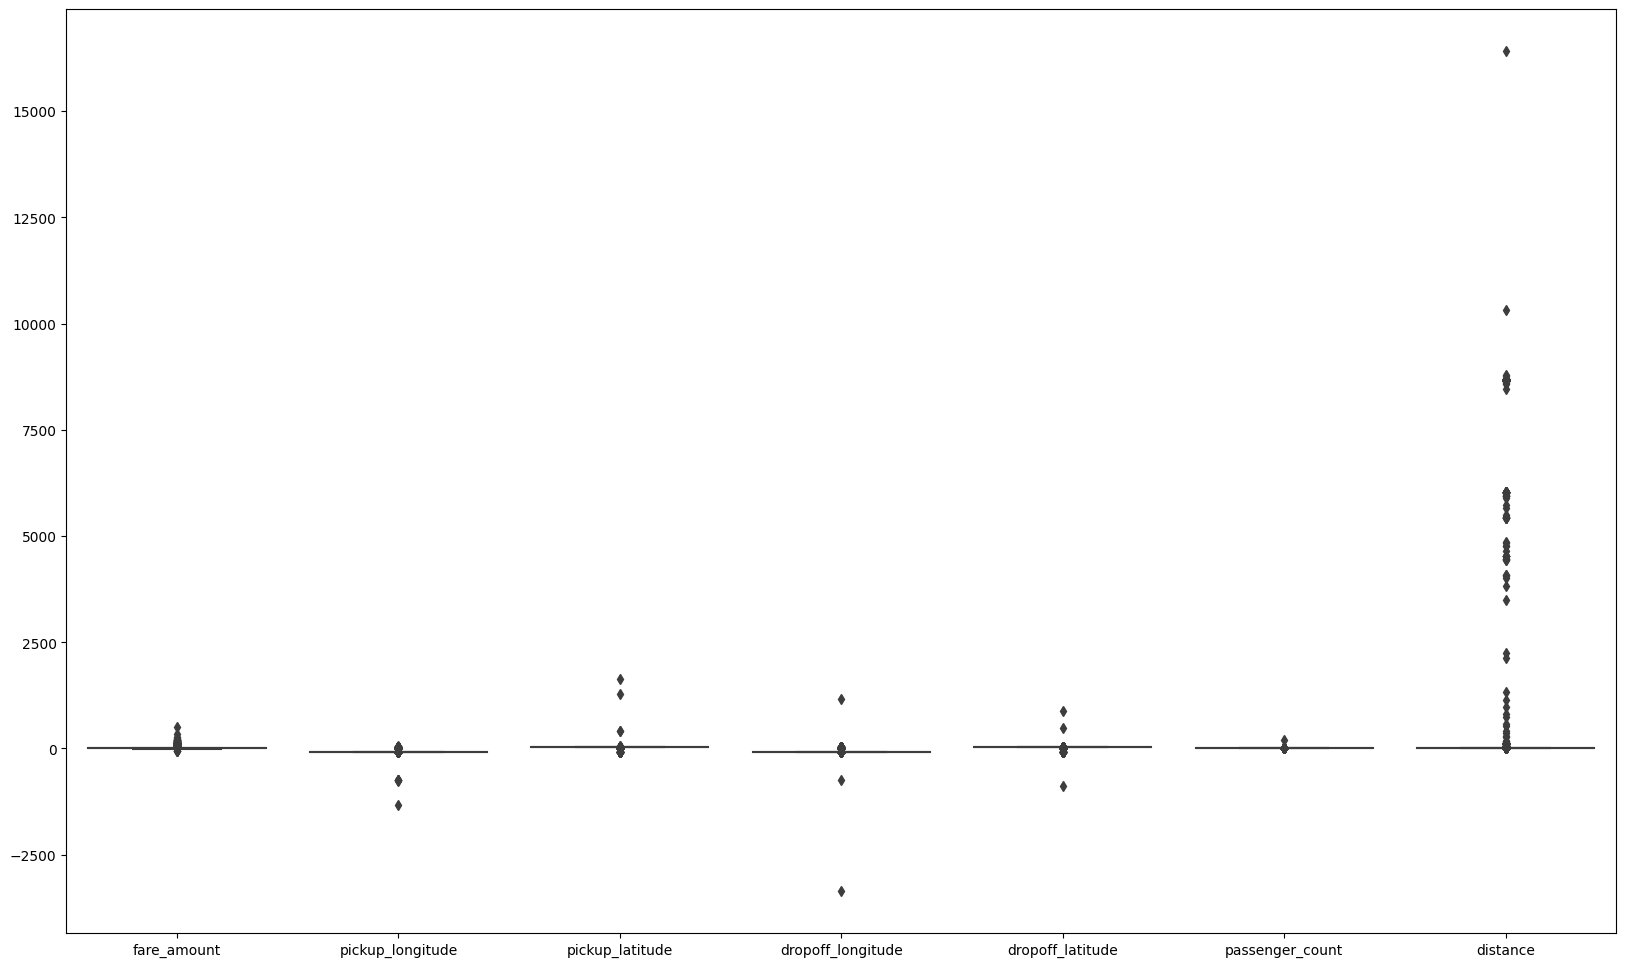

In [17]:
plt.figure(figsize=(20,12))
sns.boxplot(data = df)

Observation - distance column has very large number of outliers

In [18]:
df.drop(df[df['distance'] >= 60].index, inplace = True)     # 1.
df.drop(df[df['fare_amount'] <= 0].index, inplace = True)   # 2.
 

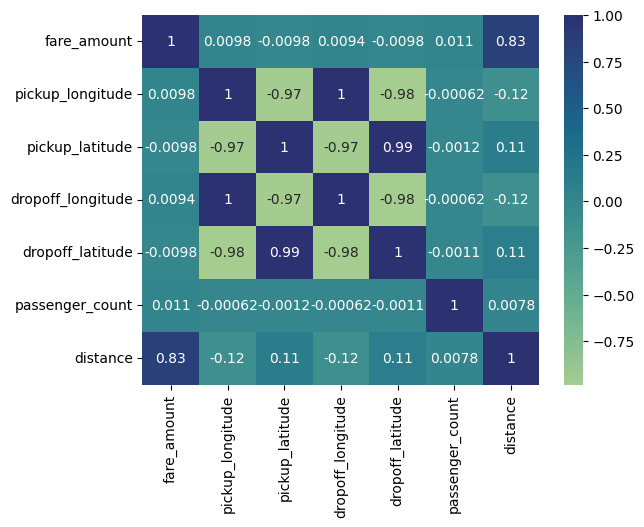

In [19]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='crest', annot=True)
plt.show()

# Dependent and Independent Variables

In [32]:
X = df['distance'].values.reshape(-1, 1)
y = df['fare_amount'].values.reshape(-1, 1)

0          7.5
1          7.7
2         12.9
3          5.3
4         16.0
          ... 
199995     3.0
199996     7.5
199997    30.9
199998    14.5
199999    14.1
Name: fare_amount, Length: 199484, dtype: float64

StandardScaler is used for standardization or z-score normalization. It scales the data such that it has a mean of 0 and a standard deviation of 1. 

# Splitting the Dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Simple Linear Regression

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [45]:
y_pred = lr.predict(X_test)
result = pd.DataFrame()
result[['Actual']] = y_test
result[['Predicted']] = y_pred
result.sample(10)

,Actual,Predicted
11513,5.00,4.427011
31615,7.70,11.507073
28288,6.50,7.533347
36041,12.90,8.760248
21135,6.50,8.451491
34886,10.00,7.471066
22961,5.00,6.145622
13091,12.90,11.950443
32255,31.33,22.431300
7204,5.50,12.326294


Creating a DataFrame (result) to compare the actual and predicted values.

In [47]:
metrics.mean_squared_error(y_test, y_pred)  # MSE


29.325683942831727

In [49]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))  # RMSE

5.415319375884651

In [50]:
metrics.r2_score(y_test, y_pred)  # R2

0.7044792161555629

# RandomForestRegressor

In [38]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

n_estimators=100: This parameter specifies the number of decision trees (or estimators) that will be used in the random forest.
    
random_state=10: This parameter sets the random seed for reproducibility. 
By setting a random seed, you ensure that the randomness introduced in the algorithm is consistent across different runs

In [52]:
print("Training set score: {:.2f}".format(rf_reg.score(X_train, y_train)))
print("Test set score: {:.7f}".format(rf_reg.score(X_test, y_test)))

Training set score: 0.90
Test set score: 0.6198645


In [53]:
y_pred_RF = rf_reg.predict(X_test)
result = pd.DataFrame()
result[['Actual']] = y_test
result['Predicted'] = y_pred_RF
result.sample(10)

,Actual,Predicted
23328,14.5,4.052057
17404,7.3,8.948000
9455,14.9,16.756000
18091,6.5,7.729000
1067,16.0,7.687000
34800,10.5,10.519000
24490,5.5,6.496000
36859,9.5,7.746000
638,5.5,6.400000
6884,21.5,4.928000


In [54]:
metrics.mean_squared_error(y_test, y_pred_RF)  # MSE


(37.72233062671854,)

In [55]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF))  # RMSE


(6.141850749303384,)

In [56]:
metrics.r2_score(y_test, y_pred_RF)

0.6198645277300754